# Lib Imports

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math
from vowpalwabbit import pyvw

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Generate Data

In [207]:
x, y = make_classification(n_samples=100000, n_features=2, n_informative=2, n_redundant=0)

In [208]:
x_coordinates = [i[0] for i in x]
y_coordinates = [j[1] for j in x]

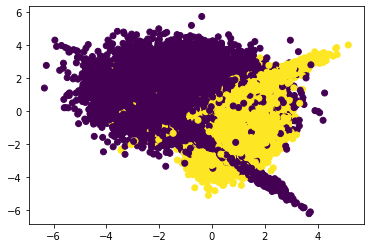

In [209]:
plt.scatter(x_coordinates, y_coordinates, c=y)

In [190]:
x2, y2 = make_classification(n_samples=100000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2)

In [191]:
x_coordinates2 = [i[0] for i in x2]
y_coordinates2 = [j[1] for j in x2]

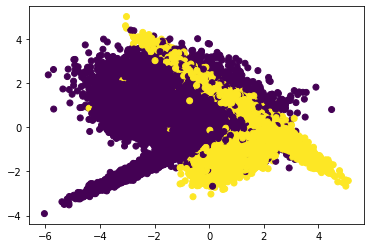

In [192]:
plt.scatter(x_coordinates2, y_coordinates2, c=y2)
plt.show()

# Introduce Transition

In [210]:
df = pd.DataFrame(x)

In [211]:
df['y'] = y

In [212]:
df = df.reset_index()

In [213]:
df['switch'] = np.random.rand(len(df)) < (df['index']/len(df))

In [214]:
df['y_new'] = df['y']

In [215]:
df.loc[df['switch'] == True, 'y_new'] = np.abs(df.loc[df['switch'] == True, 'y']-1)

In [216]:
df.head()

,index,0,1,y,switch,y_new
0,0,2.905704,2.723168,1,False,1
1,1,1.401127,-0.190840,1,False,1
2,2,2.540288,2.553694,1,False,1
3,3,3.032171,-1.116236,1,False,1
4,4,1.307164,-3.381134,0,False,0


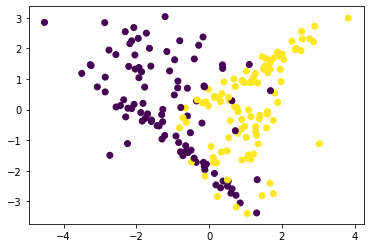

In [217]:
##Start Distribution
plt.scatter(df[0][0:200], df[1][0:200], c=df['y_new'][0:200])

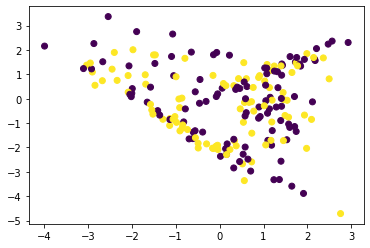

In [218]:
##Median Distribution
plt.scatter(df[0][50000:50200], df[1][50000:50200], c=df['y_new'][50000:50200])

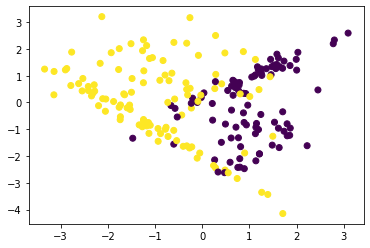

In [219]:
##End Distribution
plt.scatter(df[0][-200:], df[1][-200:], c=df['y_new'][-200:])

## Random Forest

In [115]:
x_cols = [0,1]
y_cols = ['y_new']

interval = 10000

static_batch_acc = []
historic_batch_acc = []
recent_batch_acc = []

static_rf = RandomForestClassifier()

static_train_interval = df[:interval]
x_train_static = static_train_interval[x_cols]
y_train_static = static_train_interval[y_cols]

static_rf.fit(x_train_static,np.ravel(y_train_static))

for i in range(1,10):
    print(f"Starting batch {i}")
    train_interval_hist = df[:i*interval]
    x_train_hist = train_interval_hist[x_cols]
    y_train_hist = train_interval_hist[y_cols]
    
    train_interval_recent = df[(i-1)*interval:i*interval]
    x_train_recent = train_interval_recent[x_cols]
    y_train_recent = train_interval_recent[y_cols]
    
    test_interval = df[i*interval:(i+1)*interval]
    x_test = test_interval[x_cols]
    y_test = test_interval[y_cols]
    
    historic_batch_rf = RandomForestClassifier()
    historic_batch_rf.fit(x_train_hist, np.ravel(y_train_hist))
    y_pred_hist = historic_batch_rf.predict(x_test)
    historic_batch_acc.append(accuracy_score(y_test, y_pred_hist))

    recent_batch_rf = RandomForestClassifier()
    recent_batch_rf.fit(x_train_recent, np.ravel(y_train_recent))
    y_pred_recent = recent_batch_rf.predict(x_test)
    recent_batch_acc.append(accuracy_score(y_test, y_pred_recent))
    
    y_pred_static = static_rf.predict(x_test)
    static_batch_acc.append(accuracy_score(y_test, y_pred_static))

In [116]:
historic_batch_acc

[0.8206, 0.7227, 0.6315, 0.5405, 0.4579, 0.4144, 0.3771, 0.3753, 0.4132]

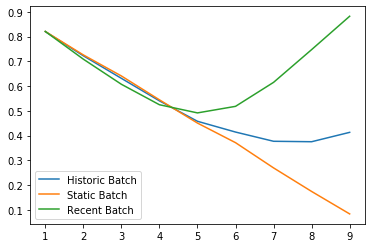

In [132]:
x_axis = np.linspace(1,len(historic_batch_acc), len(historic_batch_acc))

plt.plot(x_axis, historic_batch_acc, label='Historic Batch')
plt.plot(x_axis, static_batch_acc, label='Static Batch')
plt.plot(x_axis, recent_batch_acc, label='Recent Batch')
plt.legend(loc='best')
plt.show()

In [119]:
np.linspace(0,len(historic_batch_acc),10)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Online Learning

In [140]:
df.columns = ['index', 'x_0', 'x_1', 'y', 'switch', 'y_new']

In [143]:
df = df[['x_0','x_1','y_new']]

In [145]:
for _, row in df.iterrows():
    print()
    print(row)
    break


x_0      1.206974
x_1      1.362589
y_new    1.000000
Name: 0, dtype: float64


In [156]:
def df_to_vw_classification(df,filepath='mc.txt', columns=None, target=None, namespace='n'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in df.iterrows():
            if namespace:
                f.write(f"{row[target]}  |{namespace} ")
            else:
                f.write(f"{row[target]} | ")
            last_feature = columns[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write(f"{val.replace(' ', '_').replace(':', '_')}")
                elif (isinstance(val, float) or isinstance(val, int)):
                    if not math.isnan(val):
                        f.write(f"{idx.replace(' ', '_').replace(':', '_')}:{val}")
                    else:
                        continue
                else:
                    f.write(f"{val.replace(' ', '_').replace(':', '_')}")
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')

In [157]:
df_to_vw_classification(df, target='y_new')

In [160]:
!vw -d mc.txt -f model.vw -p preds.csv

final_regressor = model.vw
predictions = preds.csv
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = mc.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000        3
0.833634 0.667267            2            2.0   1.0000   0.1831        3
0.452171 0.070709            4            4.0   0.0000   0.2302        3
0.240543 0.028916            8            8.0   1.0000   0.7617        3
0.212860 0.185176           16           16.0   1.0000   0.6223        3
0.146336 0.079812           32           32.0   1.0000   1.0000        3
0.109961 0.073586           64           64.0   0.0000   0.0000        3
0.095041 0.080122          128          128.0   0.0000   0.3712        3
0.068925 0.042808          256          256.0   0.0000   0.0000        3
0.063278 0.057632   

In [173]:
y_preds_vw = pd.read_csv('preds.csv', header=None)

In [165]:
y_test_vw = df['y_new']

In [166]:
y_test_vw

0        1
1        1
2        0
3        0
4        0
        ..
99995    1
99996    1
99997    0
99998    0
99999    0
Name: y_new, Length: 100000, dtype: int64

In [174]:
y_preds_vw = np.round(y_preds_vw)

In [175]:
y_preds_vw

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
99995,1.0
99996,1.0
99997,1.0
99998,0.0


In [176]:
interval = 10000

vw_acc = []

for i in range(10):
    y_pred = y_preds_vw[i*interval:(i+1)*interval]
    y_test = y_test_vw[i*interval:(i+1)*interval]
    
    vw_acc.append(accuracy_score(y_test, y_pred))
    

In [178]:
len(vw_acc)

10

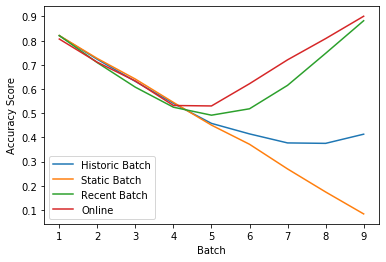

In [195]:
x_axis = np.linspace(1,len(historic_batch_acc), len(historic_batch_acc))

plt.plot(x_axis, historic_batch_acc, label='Historic Batch')
plt.plot(x_axis, static_batch_acc, label='Static Batch')
plt.plot(x_axis, recent_batch_acc, label='Recent Batch')

plt.plot(x_axis, vw_acc[1:], label='Online')

plt.xlabel('Batch')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()

# 2 Data Set Case

In [ ]:
x1, y1 = make_classification(n_samples=100000, n_features=2, n_informative=2, n_redundant=0)

In [ ]:
x2, y2 = make_classification(n_samples=100000, n_features=2, n_informative=2, n_redundant=0)